# Full Pipeline Test: Detection + OCR

**`license_plate_detector.keras`**

**`ocr_model.keras`**

In [ ]:
import os
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageOps
from datasets import load_dataset
from tensorflow.keras import layers

IMG_SIZE_DETECTION = 416
GRID_SIZE = 13
OBJ_THRESHOLD = 0.5

IMG_WIDTH_OCR = 200
IMG_HEIGHT_OCR = 50
MAX_LENGTH = 10

CHARACTERS = string.digits + string.ascii_uppercase
char_to_num = layers.StringLookup(
    vocabulary=list(CHARACTERS), mask_token=None, num_oov_indices=0
)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, num_oov_indices=0, invert=True
)

## 1. Load Models & Dataset

In [ ]:
print("Loading dataset...")
ds = load_dataset("keremberke/license-plate-object-detection", name="full")
test_ds = ds["test"]

print("Loading Detection Model...")
detection_model = tf.keras.models.load_model(
    "license_plate_detector.keras", 
    compile=False
)

print("Loading OCR Model (Real Data)...")
ocr_model = tf.keras.models.load_model(
    "ocr_model_real.keras",
    compile=False
)

Loading dataset...
Loading Detection Model...
Loading OCR Model (Real Data)...


## 2. Helper Functions

In [ ]:
def utils_resize_with_pad(image, target_size):
    if not tf.is_tensor(image):
        image = tf.convert_to_tensor(np.array(image))
        
    shape = tf.cast(tf.shape(image), tf.float32)
    h, w = shape[0], shape[1]
    target_size_float = tf.cast(target_size, tf.float32)
    target_size_int = tf.cast(target_size, tf.int32)
    
    scale = tf.minimum(target_size_float / w, target_size_float / h)
    new_w = tf.cast(w * scale, tf.int32)
    new_h = tf.cast(h * scale, tf.int32)
    
    image = tf.image.resize(image, (new_h, new_w))
    image = tf.image.resize_with_pad(image, target_size_int, target_size_int)
    
    pad_w = (target_size_float - tf.cast(new_w, tf.float32)) / 2.0
    pad_h = (target_size_float - tf.cast(new_h, tf.float32)) / 2.0
    return image, scale, pad_w, pad_h

def detect_plate(image):
    img_tensor, scale, pad_w, pad_h = utils_resize_with_pad(image, IMG_SIZE_DETECTION)
    img_tensor = tf.cast(img_tensor, tf.float32) / 255.0

    pred = detection_model(tf.expand_dims(img_tensor, 0), training=False)

    obj = tf.sigmoid(pred[0, ..., 0])
    box = tf.sigmoid(pred[0, ..., 1:5])

    max_idx = tf.argmax(tf.reshape(obj, [-1]))
    gy = int(max_idx // GRID_SIZE)
    gx = int(max_idx % GRID_SIZE)

    confidence = obj[gy, gx].numpy()
    if confidence < OBJ_THRESHOLD:
        return None, None, confidence

    x_rel, y_rel, w, h = box[gy, gx].numpy()
    pad_w = float(pad_w)
    pad_h = float(pad_h)
    scale = float(scale)

    xc = (gx + x_rel) / GRID_SIZE
    yc = (gy + y_rel) / GRID_SIZE
    
    xc_px = xc * IMG_SIZE_DETECTION - pad_w
    yc_px = yc * IMG_SIZE_DETECTION - pad_h
    w_px = w * IMG_SIZE_DETECTION
    h_px = h * IMG_SIZE_DETECTION

    xc_orig = xc_px / scale
    yc_orig = yc_px / scale
    w_orig = (w_px / scale) * 1.15
    h_orig = (h_px / scale) * 1.15

    x1 = max(0, int(xc_orig - w_orig / 2))
    y1 = max(0, int(yc_orig - h_orig / 2))
    x2 = min(image.width, int(xc_orig + w_orig / 2))
    y2 = min(image.height, int(yc_orig + h_orig / 2))

    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(image.width, x2), min(image.height, y2)

    if x2 <= x1 or y2 <= y1:
        return None, None, 0.0

    plate_img = image.crop((x1, y1, x2, y2))
    return plate_img, (x1, y1, x2, y2), confidence

def read_plate(plate_img):

    img = plate_img.convert("L") 
    img = img.resize((IMG_WIDTH_OCR, IMG_HEIGHT_OCR))
    img_arr = np.array(img).astype(np.float32) / 255.0
    
    img_arr = np.expand_dims(img_arr, axis=-1)
    
    img_arr = np.transpose(img_arr, (1, 0, 2))
    
    img_arr = np.expand_dims(img_arr, axis=0)

    preds = ocr_model.predict(img_arr, verbose=0)
    
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    results = tf.keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :MAX_LENGTH]
    
    res = results[0]
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    
    if tf.size(res) > 0:
        text = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    else:
        text = ""
        
    return text, img

## 3. Run Inference on Test Set

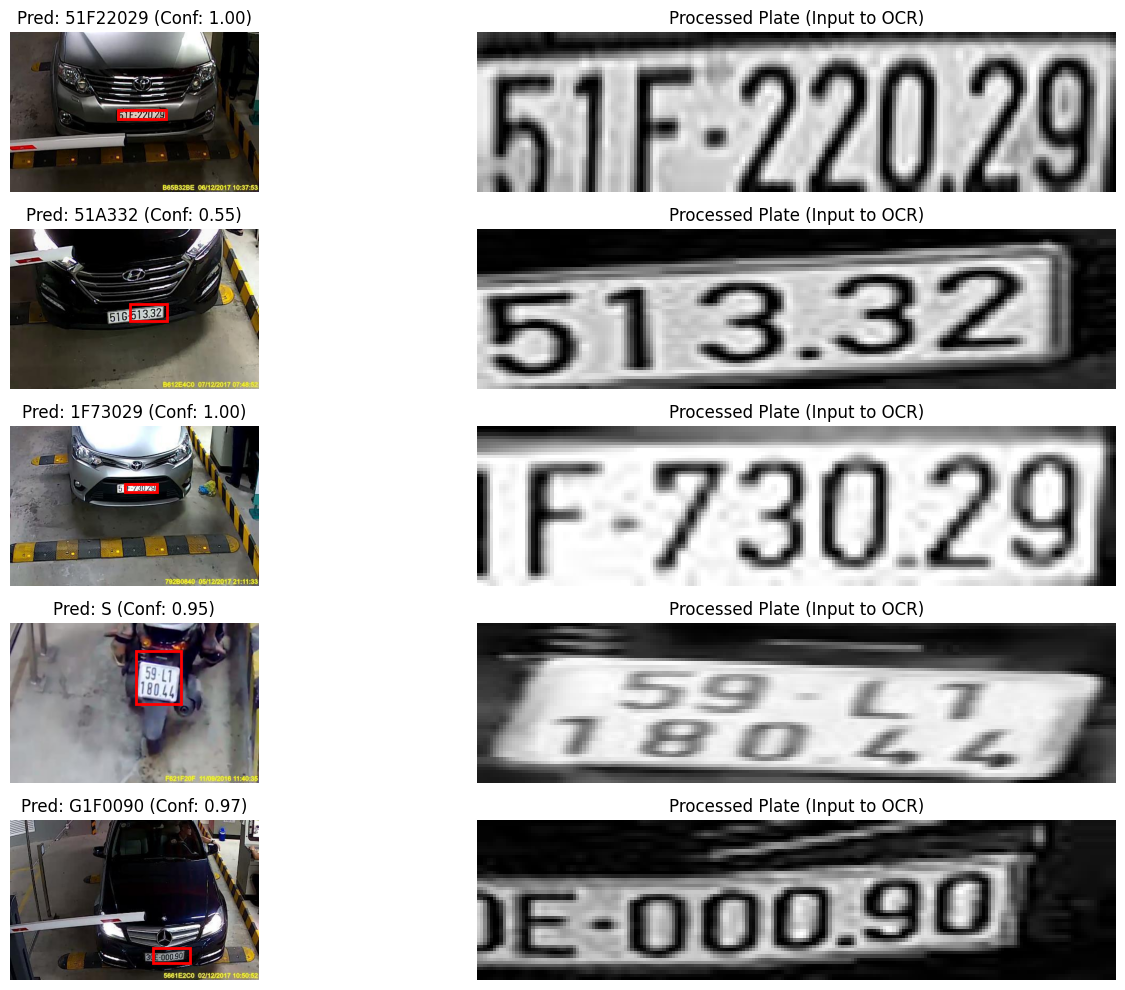

In [ ]:
import random

num_samples = 5
samples = random.sample(list(test_ds), num_samples)

plt.figure(figsize=(15, 10))

for i, sample in enumerate(samples):
    original_image = sample["image"]
    
    plate_crop, box, conf = detect_plate(original_image)
    
    processed_plate = None
    if plate_crop is not None:
        predicted_text, processed_plate = read_plate(plate_crop)
        title_text = f"Pred: {predicted_text} (Conf: {conf:.2f})"
        rect_color = "red"
    else:
        title_text = "No Plate Detected"
        box = None
        rect_color = "none"
    
    ax = plt.subplot(num_samples, 2, 2*i + 1)
    ax.imshow(original_image)
    ax.set_title(title_text)
    ax.axis("off")
    
    if box:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=rect_color, facecolor="none")
        ax.add_patch(rect)

    if processed_plate:
        ax2 = plt.subplot(num_samples, 2, 2*i + 2)
        ax2.imshow(processed_plate, cmap="gray")
        ax2.set_title("Processed Plate (Input to OCR)")
        ax2.axis("off")
    elif plate_crop:
        ax2 = plt.subplot(num_samples, 2, 2*i + 2)
        ax2.imshow(plate_crop)
        ax2.set_title("Cropped (Raw)")
        ax2.axis("off")

plt.tight_layout()
plt.show()